In [1]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cols = ['Gender', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df = pd.read_csv('abalone.csv', names = cols)
df = df.join(pd.get_dummies(df['Gender'], prefix = 'Gender')).drop(columns = ['Gender'])

def label(r):
    if r == 9:
        return 1
    else:
        return np.sign(r-9)

df['Rings_label'] = df['Rings'].apply(lambda x: label(x))

col_order_2 = ['Rings_label','Gender_-1','Gender_0','Gender_1', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
df =  df[col_order_2]
display(df.head())

X_train = df.iloc[:3133, 1:].values
y_train = df.iloc[:3133,0].values

X_all = df.iloc[:,1:].values
y_all = df.iloc[:, 0].values

,Rings_label,Gender_-1,Gender_0,Gender_1,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,-1,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,1,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,1,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,-1,0,1,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [5]:
ada_CV = []

for i in range(10):    
    adaBoost = GradientBoostingClassifier(loss = 'exponential', n_estimators = 100*(1+i), max_depth = 1, random_state=0)
    adaBoost.fit(X_train, y_train)
    
    results  = cross_validate(adaBoost, X_all, y_all, cv=10)
    ada_CV.append(results['test_score'].mean())


0
1
2
3
4
5
6
7
8
9


In [6]:
logit_CV = []

for i in range(10):
    logitBoost = GradientBoostingClassifier(loss = 'deviance', n_estimators = 100*(1+i) , max_depth = 1, random_state=0)
    logitBoost.fit(X_train, y_train)
    
    results = cross_validate(logitBoost, X_all, y_all, cv=10)
    logit_CV.append(results['test_score'].mean())

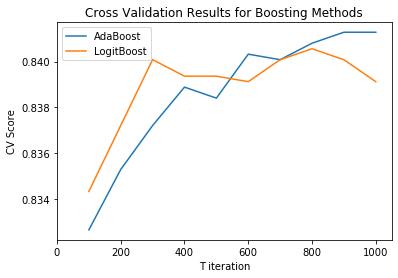

In [8]:
x_axis = [100, 200, 300, 400, 500, 600, 700, 800, 900,1000]

plt.plot(x_axis, ada_CV, label = 'AdaBoost')
plt.plot(x_axis, logit_CV, label = 'LogitBoost')
plt.legend()
plt.title('Cross Validation Results for Boosting Methods')
plt.xlabel('T iteration')

plt.ylabel('CV Score')
plt.xlim(0,1050,50)
plt.show()


Below is the Code that I wrote directly from pseudocode. I worked with Yixiang Gao at this question. 

In [ ]:
T = 200

def data_slice(df):
    batch = []
    for i in range(30):
        temp = df.iloc[100*i:100*(i+1)]
        temp['dist'] = 1/3000
        temp['pred']  = 0
        batch.append(temp)
    return batch

data_batch = data_slice(train_df)
data       = pd.concat(data_batch)

# display
data_batch[29]

data_batch[0].iloc[:,1:9]


# construct 30 classifiers: 
h_list = []

for i in range(30):
    X = data_batch[i].iloc[:,1:9].values
    y = data_batch[i].iloc[:,0].values 
    clf_  = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    h_list.append(clf_.fit(X, y))

# a demonstration of one classification
#for i in range(30):
#    print(h_list[i].score(X_test,y_test))

alphat = pd.DataFrame(data = np.zeros((T,2)), columns =['alpha','model'] )

def Phi_p(x):
    return -1/(np.log(2)*(1+np.exp(x)))

# Logistic Boost

for t in range(T):
    #temporary error
    error = np.zeros(3000)
    error_list = np.zeros(30)
    predict_list = np.zeros(3000)
    #predict for each base classifier to get error. 
    for i in range(30):
        y_pred   = h_list[i].predict(X_train)
        error    = abs(y_pred - y_train)/2
        
        error    = error*data['dist']
        error_list[i] = error.sum()

    n, e = error_list.argmin(), error_list.min()
    alpha = 1/2*np.log((1-e)/e)

    alphat.iloc[t] = [alpha, n]
    predict_list   = h_list[n].predict(X_train)

    data['pred']   = data['pred'] + alpha*predict_list

    Z = 0

    for i in range(3000):
        Z = Z + Phi_p(y_train[i]*data['pred'][i])
        
    for i in range(3000):
        data['dist'][i] = Phi_p(y_train[i]*data['pred'][i])/Z

def pred(x):
    pred = np.zeros(len(x))
    for i in range(T):
        pred = pred + h_list[int(alphat['model'][i])].predict(x)*alphat['alpha'][i]
    return np.sign(pred)

alphat.tail(50)

acc  = (pred(X_test) == y_test).sum()/len(X_test)